# Fine-tuning EfficientNet for identifying pneumonia in chest scans

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import random
from PIL import Image
import torchvision.transforms as tfms
from torchsummary import summary


In [2]:
%load_ext autoreload
%autoreload 2

### GPUs will be necessary to train in a reasonable time

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd /content/drive/MyDrive/ML_2024/MLCourse_2024/Tutorial6_transfer_learning/

### Download the Chest X-Ray Images (Pneumonia) dataset

5,863 X-Ray images of chests of healthy patients and patients with pneumonia

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

 ![ lungs.png ](lungs.png)

In [6]:
#! curl -L --output chest_xray.zip "https://www.dropbox.com/s/di6j323078za4qd/chest_xray.zip?dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    60    0    60    0     0    132      0 --:--:-- --:--:-- --:--:--   133
100   321  100   321    0     0    330      0 --:--:-- --:--:-- --:--:--   330
100   491    0   491    0     0    280      0 --:--:--  0:00:01 --:--:--   659
100 77.1M  100 77.1M    0     0  7009k      0  0:00:11  0:00:11 --:--:-- 8945k


In [7]:
#! unzip -o chest_xray.zip

Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: __MACOSX/._chest_xray   
  inflating: chest_xray/.DS_Store    
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: __MACOSX/chest_xray/._test  
   creating: chest_xray/val/
  inflating: __MACOSX/chest_xray/._val  
   creating: chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/._PNEUMONIA  
   creating: chest_xray/test/NORMAL/
  inflating: __MACOSX/chest_xray/test/._NORMAL  
   creating: chest_xray/val/PNEUMONIA/
  inflating: __MACOSX/chest_xray/val/._PNEUMONIA  
   creating: chest_xray/val/NORMAL/
  inflating: __MACOSX/chest_xray/val/._NORMAL  
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMO

In [8]:
#images_normal_train = glob.glob('chest_xray/train/NORMAL/*.jpeg')
#images_pneumo_train = glob.glob('chest_xray/train/PNEUMONIA/*.jpeg') # <-- for this exercise we'll train on the (smaller) testing set only
images_normal_valid = glob.glob('chest_xray/val/NORMAL/*.jpeg')
images_pneumo_valid = glob.glob('chest_xray/val/PNEUMONIA/*.jpeg')
images_normal_test = glob.glob('chest_xray/test/NORMAL/*.jpeg')
images_pneumo_test = glob.glob('chest_xray/test/PNEUMONIA/*.jpeg')

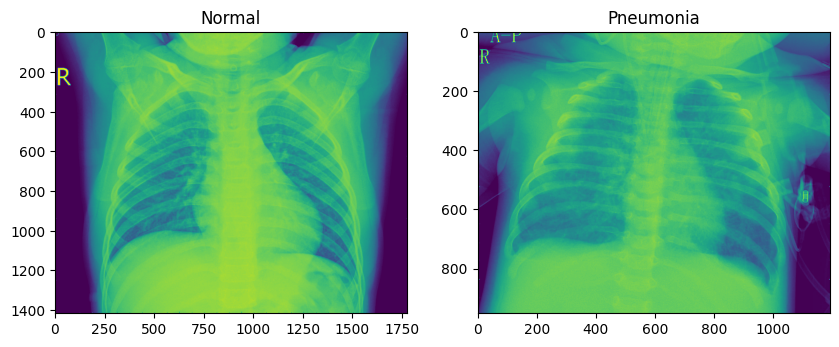

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(plt.imread(images_normal_valid[random.randint(0,len(images_normal_valid)-1)]))
axes[0].set_title('Normal')
axes[1].imshow(plt.imread(images_pneumo_valid[random.randint(0,len(images_pneumo_valid)-1)]))
axes[1].set_title('Pneumonia')
plt.show()

### Create torch Dataset

In [10]:
class ChestData(Dataset):

    def __init__(self, images_normal, images_pneumo):

        self.images = images_normal + images_pneumo
        self.labels = [0]*len(images_normal) + [1]*len(images_pneumo)
    
    def __len__(self):

        return len(self.labels)
    
    def  __getitem__(self, idx):

        img = Image.open(self.images[idx]).convert('RGB')
        lbl = self.labels[idx]

        ### The usual transforms (img -> tensor -> resize -> normalize)
        transform = tfms.Compose([
            tfms.ToTensor(),
            tfms.Resize((256,256)),
            tfms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225]),
        ])

        img_tensor = transform(img)
        return img_tensor, lbl

In [11]:
train_dataset = DataLoader(ChestData(images_normal_test, images_pneumo_test), batch_size=16, shuffle=True)
valid_dataset = DataLoader(ChestData(images_normal_valid, images_pneumo_valid), batch_size=16, shuffle=True)

### Define our pretrained model + custom fine-tuning linear layer

- we start from EfficientNet_B6 and load the pre-trained weights
- then we replace the final classifier layer with our own
- we retrain our transfer-learning model on the new dataset. 
  - Note that _only_ the classifier layer is being retrained.
  - It relies on the feature extraction of the pretrained model

In [14]:
### Following https://blog.paperspace.com/detecting-and-localizing-pneumonia-from-chest-x-ray-scans-with-pytorch/

class TransferNet(nn.Module):
    def __init__(self,freeze_pretrained=True):
        super(TransferNet,self).__init__()

        ### Load the pretrained model
        pretrained_weights = models.get_weight("EfficientNet_B6_Weights.IMAGENET1K_V1")
        self.model = models.efficientnet_b6(weights=pretrained_weights)

        ### We can freeze the pretrained parameters (i.e. don't compute gradients for them)
        if freeze_pretrained:
            for params in self.model.parameters():
                params.requires_grad = False

        ### Our new binary classifier layer
        ### Input shape is same as the input shape of the pre-trained classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 1),
            nn.Sigmoid()
        )

        ### Replace the previous classifier with our trainable one
        self.model.classifier = self.classifier

    def forward(self, x):
        return self.model(x)

In [15]:
net = TransferNet()

In [18]:
### How many trainable parameters does it have?
Ntrainable = sum(p.numel() for p in net.classifier[0].parameters())
Ntrainable

2305

In [19]:
optimizer = torch.optim.Adam(net.classifier.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4)

In [137]:
Nepochs = 5
loss = nn.BCELoss()
losses_train = []
losses_valid = []

device = torch.device("cpu")
if torch.cuda.is_available():
  print('Found GPU!')
  device = torch.device("cuda:0")

net.to(device)

for epoch in range(Nepochs):

    #Training
    net.train()
    scheduler.step()
    losses_train_epoch = []

    for batch in tqdm(train_dataset):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = net(X).squeeze(-1)
        loss_train = loss(y_pred, y.float())
        loss_train.backward()
        optimizer.step()
        losses_train_epoch.append(loss_train.item())

    losses_train.append(np.mean(losses_train_epoch))

    #Validation
    net.eval()
    losses_valid_epoch = []

    with torch.no_grad():
        for batch in tqdm(valid_dataset):
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X).squeeze(-1)
            loss_val = loss(y_pred, y.float())
            losses_valid_epoch.append(loss_val.item())

    losses_valid.append(np.mean(losses_valid_epoch))

    if epoch > 0:
        if losses_valid[-1] < min(losses_valid[:-1]):
            torch.save(net.state_dict(), 'saved_model.pt')

    print('Epoch: ',epoch,' Train loss: ',losses_train[-1],' Valid loss: ',losses_valid[-1])

Found GPU!


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Train loss:  0.5472011734277774  Valid loss:  0.5928264260292053


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Train loss:  0.39180796001202023  Valid loss:  0.5153569579124451


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Train loss:  0.3249538942025258  Valid loss:  0.4819903075695038


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Train loss:  0.3225139727195104  Valid loss:  0.5184646844863892


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Train loss:  0.33321009156031484  Valid loss:  0.5916309952735901


### Load the best model from training

In [20]:
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
net.eval()
net.cpu()

TransferNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
              (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

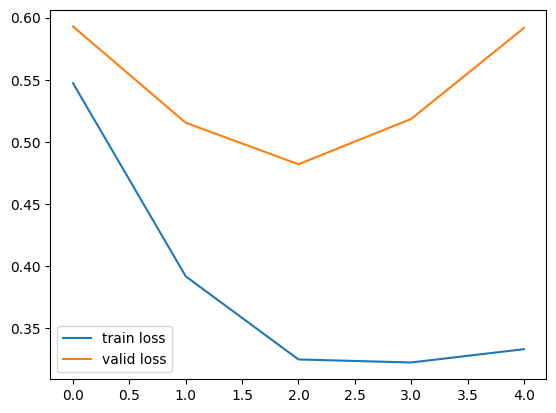

In [139]:
fig, axes = plt.subplots()
axes.plot(range(len(losses_train)),losses_train,label='train loss')
axes.plot(range(len(losses_valid)),losses_valid,label='valid loss')
axes.legend()
plt.show()

### Check accuracy

In [22]:
scores, preds = [], []
acc = 0

print("Label, Pred")
for example, label in ChestData(images_normal_valid, images_pneumo_valid):
    score = net(example.unsqueeze(0)).squeeze(-1).item()
    pred = 1 if score>0.5 else 0
    print(label,pred)
    if pred==label:
        acc += 1
    
    scores.append(score)
    preds.append(pred)

print('=============')
print(f'Got {acc}/{len(preds)} correct ({100*acc/len(preds)}%)')

Label, Pred
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 1
1 1
1 1
1 0
1 1
1 0
1 0
Got 12/16 correct (75.0%)


In [23]:
scores

[0.14112204313278198,
 0.3735109567642212,
 0.20559777319431305,
 0.4833085238933563,
 0.22332897782325745,
 0.28404662013053894,
 0.36926203966140747,
 0.36354807019233704,
 0.2942357361316681,
 0.6838325262069702,
 0.7558825612068176,
 0.7996010184288025,
 0.4111131727695465,
 0.7720298767089844,
 0.2229493409395218,
 0.36218395829200745]

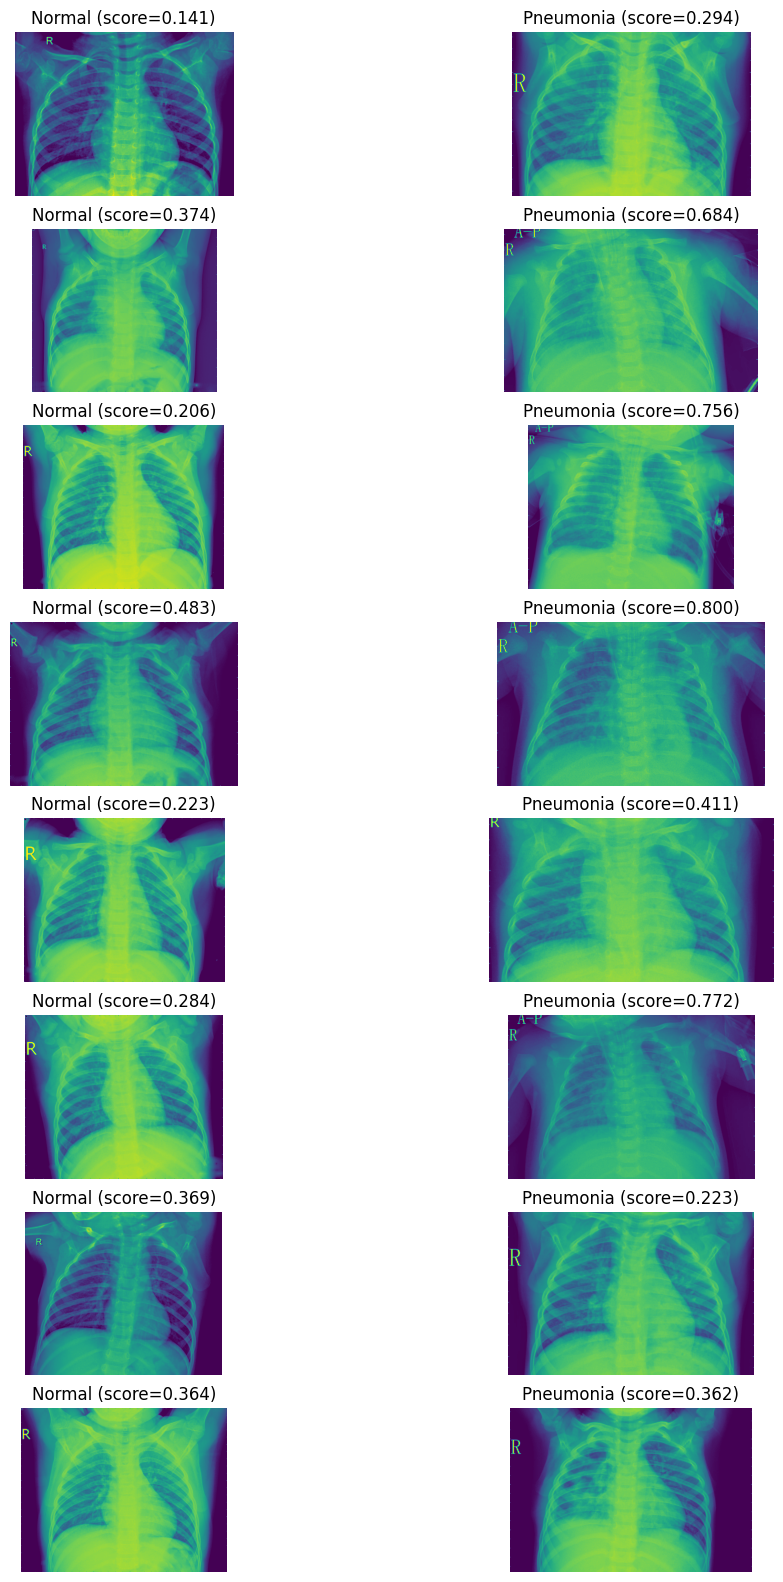

In [24]:
fig, axes = plt.subplots(8, 2, figsize=(12, 20))

for i in range(8):
    axes[i,0].imshow(plt.imread(images_normal_valid[i]))
    axes[i,0].set_title(f'Normal (score={scores[i]:.3f})')
    axes[i,0].set_axis_off()
    axes[i,1].imshow(plt.imread(images_pneumo_valid[i]))
    axes[i,1].set_title(f'Pneumonia (score={scores[i+8]:.3f})')
    axes[i,1].set_axis_off()

plt.show()